Packages

In [59]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math
from skimage import color
from skimage.transform import rescale, resize
import scipy as scp
from skimage.segmentation import active_contour
from scipy import signal
from matlab import engine

In [29]:
#load in image
I= np.asarray(Image.open('test.jpg').convert("L"), dtype=float)
pikachu = np.asarray(Image.open('pikachu.jpg').convert("RGB"),dtype=int)
van_gogh = np.asarray(Image.open('van_gogh.jpg').convert("RGB"),dtype=int)

In [3]:
from skimage.exposure import cumulative_distribution
#source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
def cdf(im):
    c, b = cumulative_distribution(im) 
    # pad the beginning and ending pixels and their CDF values
    c = np.insert(c, 0, [0]*b[0])
    c = np.append(c, [1]*(255-b[-1]))
    return c

def hist_matching(c, c_t, im):
    pixels = np.arange(256)
    # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of   
    # the template image at the corresponding pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
    new_pixels = np.interp(c, c_t, pixels) 
    im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
    return im

In [4]:
# add noise
def add_noise(image,sigma=50):
    row,col,ch= image.shape
    mean = 0
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.astype('uint8')
    gauss = gauss.reshape(row,col,ch)
    return (image + gauss).astype('uint8')

In [5]:
def imhistmatch(img1, img2):
    red_output = hist_matching(cdf(img1[:,:,0]),cdf(img2[:,:,0]),img1[:,:,0])
    green_output = hist_matching(cdf(img1[:,:,1]),cdf(img2[:,:,1]),img1[:,:,1])
    blue_output = hist_matching(cdf(img1[:,:,2]),cdf(img2[:,:,2]),img1[:,:,2])
    output = np.dstack((red_output,green_output,blue_output))
    return output

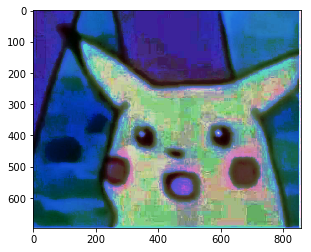

In [6]:
output = imhistmatch(pikachu, van_gogh)
plt.imshow(output)

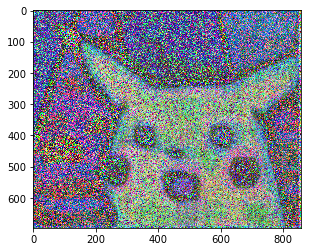

In [7]:
noisy_output = add_noise(output)
plt.imshow(noisy_output)

In [8]:
def gaussian2D(sigma=0.5):
    """
    2D gaussian filter
    """

    size = int(math.ceil(sigma * 6))
    if (size % 2 == 0):
        size += 1
    r, c = np.ogrid[-size / 2: size / 2 + 1, -size / 2: size / 2 + 1]
    g = np.exp(-(c * c + r * r) / (2. * sigma ** 2))
    g = g / (g.sum() + 0.000001)
    
    return g

In [9]:
def laplace_of_gaussian(gray_img, sigma=1., kappa=0.75, pad=False):
    """
    Applies Laplacian of Gaussians to grayscale image.

    :param gray_img: image to apply LoG to
    :param sigma:    Gauss sigma of Gaussian applied to image, <= 0. for none
    :param kappa:    difference threshold as factor to mean of image values, <= 0 for none
    :param pad:      flag to pad output w/ zero border, keeping input image size
    """
    assert len(gray_img.shape) == 2
    img = cv2.GaussianBlur(gray_img, (0, 0), sigma) if 0. < sigma else gray_img
    img = cv2.Laplacian(img, cv2.CV_64F)
    rows, cols = img.shape[:2]
    # min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = neg_min + pos_max
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    # optional thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(img).mean()) * kappa
        values[values < thresh] = 0.
    log_img = values.astype(np.uint8)
    if pad:
        log_img = np.pad(log_img, pad_width=1, mode='constant', constant_values=0)
    return log_img

In [68]:
def segment(img,scale):
    #E = scp.ndimage.gaussian_laplace(img, scale)
    E = laplace_of_gaussian(img,scale,0.03,True)
    #E = edge(C, 'log', 0.03, scale)
    gaussian_filter = gaussian2D(scale*7)
    B = signal.convolve2d(0.5*E,gaussian_filter,mode='same')
    mask = np.zeros_like(B)
    B_mean = np.mean(B)
    for i in range(0,B.shape[0]):
        for j in range(0,B.shape[1]):
            if B[i][j] > B_mean: 
                mask[i][j] = 1
            else:
                mask[i][j] = 0
    BW = active_contour(img,mask,max_iterations=100) #find python version
    print(BW)
    W = np.matmul((BW+10*E).astype(float),gaussian_filter)
    return BW

In [69]:
pikachu = pikachu.astype('uint8')
gray_van_gogh = color.rgb2gray(pikachu)
#ret, thresh = cv2.threshold(gray_pikachu,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
output = segment(gray_van_gogh,0.9)
plt.imshow(output, cmap='gray')

[[  0.51364585 -30.00434675]
 [  0.2486083  -30.26771908]
 [  0.13205764 -30.54050898]
 ...
 [  0.91887816 -29.30373029]
 [  0.87374099 -29.51801667]
 [  0.76580606 -29.75308994]]


ValueError: operands could not be broadcast together with shapes (696,2) (696,856) 

In [11]:
def style_transfer(content, style, hall0, mask, hallcoeff, Wcoeff, patch_sizes, scales, imsize):
    output_shape = (imsize, imsize, 3)
    #content image now has imhist applied to it, has the colors of style
    C0 = imhistmatch(resize(content, output_shape),resize(style, output_shape))
    #gaussian noise function is added to the re-colored content image
    X = add_noise(C0)
    h0,w0 = imsize
    gap_sizes = [28, 18, 9, 6]
    
    #iterate through resolutions, like a gaussian pyramid.
    for L in scales:
        content_scaled = rescale(content, 1/L)
        style_scaled = rescale(style, 1/L)
        mask = rescale(mask, 1/L)
        C = np.copy(content_scaled)
        S = np.copy(style_scaled)
        h = math.ceil(h0/L)
        w = math.ceil(w0/L)
        X = rescale(X, 1/L)
        hall = rescale(hall0,1/L)
        
        #iterate through patch sizes, like in the algorithm.
        for N in patch_sizes:
            
            p_str = 4 #Weird constant see line 39 of source
            
            current_patch = N #Conversion from source; current_patch = Q_size
            
            S = np.reshape(S, (h,w,3))
            
            #Check this shape
            P = np.zeros( (n*n*3, (math.floor((h-current_patch)/p_str)+1) * (math.floor((w-current_patch)/p_str)+1)*4))
            
            for k in range (0,(h-current_patch+2), p_str): #+2 bc python not inclusive but matlab is
                for j in range (0, (w-current_patch+2), p_str):
                    patch = S[k:(k+current_patch), j:(j+current_patch)]
                    for i in range (1,4):
                        temp = scp.misc.imrotate(patch,i*90,'bilinear')
                        
                        #Check this shape
                        P[:, math.ceil((k/p_str)-1) 
                              * ((math.floor((w-current_patch)/p_str)+1)*4 + (math.ceil(j/p_str)-1)*4 + i + 1 )] = temp
            
            #S = np.copy(S)
            
            #Remove mean
            mp = np.average(P)
            P = np.subtract(P,mp)
            
            #Compute PCA of P
            V,D = np.linalg.eig(P*P.T)
            
            D= np.sort(np.diag(D))
            I = np.argsort(np.diag(D))
            
            V = V[:,I]
            
            #Find Top eig values
            eig__index = 0
            energy_cutoff = 0.95*np.sum(D)
            for i in range(0,D.shape[0]):
                if np.sum(D[:i]) >= energy_cutoff:
                    eig__index = i
                    
            Vp = V[:eig__index]
            Pp = Vp.T * P
            
        
            for i in range (0,3):
                
                #1. Style fusion
                X = hallcoeff*hall+(1-hallcoeff)*hall
                
                #2. Patch Matching
                print("Patch Matching")
                gap = gap_sizes[np.where(patch_sizes == current_patch)]
                Rall = np.zeros(h*w*3, (math.floor((h-current_patch)/gap)+1) * (math.floor((w-current_patch)/p_str)+1))
                z = np.zeros(h*(current_patch**2), (math.floor((h-current_patch)/gap)+1) * (math.floor((w-current_patch)/p_str)+1))
        
                for j in range (1, (h-current_patch+2), gap ):
                    for j in range (1, (h-current_patch+2), gap ):
                        R = np.zeros((h,w,3))
                        R[i:i+current_patch-1, j:j+current_patch-1,:] = 1
                        
                        Rall[:,(math.ceil(i/gap)-1)*(math.floor( (w-current_patch)/gap )+ 1) + ceil(j/gap)]=R #This line is sketchie AF
                        ks, ls, zij, ang = nearest_n(R, X, current_patch, S, h, w, 3, Pp,Vp,p_str,mp,L,gap)
                        temp = scp.misc.imrotate(reshape(zij,n,n,c),ang*90,'bilinear')
                             
                        z[:,(math.ceil(i/gap)-1)*(math.floor( (w-current_patch)/gap )+ 1) + ceil(j/gap)]=temp
                
                #3. Style Synthesis        
                print("Robust Aggregation")
                Xtilde=irls(Rall,X,z)
                             
                #4. Content Fusion
                print("Content Fusion")
                W = np.tile(Wcoeff*mask/max(mask),(3,1));
                X_temp = np.matmul( W + np.ones(size(W)) , (Xtilde+ np.matmul(W,C))) #DOUBLE CHECK THIS #W is (3*Nc/L x 1)) 
                
                one_temp = np.ones(X_temp.shape)
                             
                X_hat = np.divide(one_temp, X_temp)
                             
                             
                #5. Color Transfer
                print("Color Transfer")
                X = imhistmatch(reshape(X_hat, (h,w,3)), reshape(S,(h,w,3))) 
                
                #6. Denoise
                print("Denoise")
                #COME BACK TO THIS, might be in cv2 https://docs.opencv.org/3.0-beta/modules/ximgproc/doc/edge_aware_filters.html
                #Might be in existing files
        if (L>1):
            X=resize(reshape(X, (h,w,3),L))
    return (reshape(X,imsize,imsize,3))

In [5]:
#master routine, calls style transfer. 
def master_routine():
    max_resolution = 400 
    #convert content and style to floats
    content = cv2.normalize(pikachu.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    style = cv2.normalize(van_gogh.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    #crop content and style into max_resolution 
    #content = content[0:max_resolution-1,0:max_resolution-1]
    #style = style[0:max_resolution-1,0:max_resolution-1]
    first_iteration = style_transfer(content,style,\
                                     np.ones((max_resolution,max_resolution,3)),\
                                     np.ones((max_resolution,max_resolution)),\
                                     0, \
                                     0,\
                                     [36, 22], \
                                     [4, 2, 1], \
                                    max_resolution)
    output = style_transfer(content, style, first_iteration, segment(cv2.cvtColor(content, cv2.COLOR_BGR2GRAY),1),\
                            0.25, 1.5, [36, 22, 13], [4, 2, 1], max_resolution)
    plt.imshow(output)
    